In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from jax.example_libraries import optimizers
from jax.example_libraries.optimizers import adamax as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.40'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
MB = 2 ** 8
NN_SHAPES = jnp.array([64, 64, 64, 64])
SCALE = 1e-3
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)
LAMBDA = 0.
DELTA = (1 - 1e-5) / 1000

BETA = 0.8
MAX_AGE = 2.
MIN_DP = 0.2
INTEREST = 0.5
UTILITY_CONSTANT = 1.

R = (1 + INTEREST)
B = BETA
BR = B * R
OBJECTIVE_FN = lambda x, t: jax.lax.select((jnp.where(t == 1, size=1)[0] == 2)[0], 
                                           jnp.array([jnp.log(x), 
                                                      x, 
                                                      0., 
                                                      1.]), 
                                           jax.lax.select((jnp.where(t == 1, size=1)[0] == 1)[0], 
                                                          jnp.array([jnp.log((1 / (1 + B)) * x) + BETA * jnp.log(R * (1 - (1 / (1 + B))) * x), 
                                                                     (1 / (1 + B)) * x, 
                                                                     R * (1 - (1 / (1 + B))) * x, 
                                                                     1.]), 
                                                          jax.lax.select((jnp.where(t == 1, size=1)[0] == 0)[0],
                                                              jnp.array([jnp.log((1 / (1 + B + B**2)) * x) +\
                                                                         BETA * jnp.log((1 / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x) +\
                                                                         BETA**2 * jnp.log(R * (B / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x),
                                                                         ((1) / (1 + B + B**2)) * x,
                                                                         R * (1 - ((1) / (1 + B + B**2))) * x,
                                                                         1.]),
                                                              jnp.array([0., 0., 0., 1.]))))


all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000),
                         jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000),
                                        jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000))), 4)
all_O = jnp.concatenate((jnp.ones(1000), jnp.ones(1000), jnp.ones(1000),
                         jnp.zeros(1000), jnp.zeros(1000), jnp.zeros(1000)))
all_grid = jnp.concatenate((all_X.reshape(-1, 1), all_T, all_O.reshape(-1, 1)), axis=1)

In [3]:
initializer = jax.nn.initializers.glorot_normal()
w0 = SCALE * initializer(INIT_KEYS[0], (5, NN_SHAPES[0]), jnp.float32)
w1 = SCALE * initializer(INIT_KEYS[1], (NN_SHAPES[0], NN_SHAPES[1]), jnp.float32)
w2 = SCALE * initializer(INIT_KEYS[2], (NN_SHAPES[1], NN_SHAPES[2]), jnp.float32)
ow3 = SCALE * initializer(INIT_KEYS[3], (NN_SHAPES[2] + 5, NN_SHAPES[3]), jnp.float32)
rw3 = SCALE * initializer(INIT_KEYS[3], (NN_SHAPES[2] + 6, NN_SHAPES[3]), jnp.float32)
wf = SCALE * initializer(INIT_KEYS[4], (NN_SHAPES[3], 1), jnp.float32)
b0 = SCALE * initializer(INIT_KEYS[5], (1, NN_SHAPES[0]), jnp.float32)
b1 = SCALE * initializer(INIT_KEYS[6], (1, NN_SHAPES[1]), jnp.float32)
b2 = SCALE * initializer(INIT_KEYS[7], (1, NN_SHAPES[2]), jnp.float32)
b3 = SCALE * initializer(INIT_KEYS[8], (1, NN_SHAPES[3]), jnp.float32)
bf = SCALE * initializer(INIT_KEYS[9], (1, 1), jnp.float32)
owner_params0 = {'w0': w0, 'w1': w1, 'w2': w2, 'vw3': ow3, 'cw3': ow3, 'vwf': wf, 'cwf': wf, 
                 'b0': b0, 'b1': b1, 'b2': b2, 'vb3': b3, 'cb3': b3, 'vbf': bf, 'cbf': bf}

renter_params0 = {'w0': w0, 'w1': w1, 'w2': w2, 'vw3': rw3, 'cw3': ow3, 'vwf':wf, 'cwf': wf, 
                  'b0': b0, 'b1': b1, 'b2': b2, 'vb3': b3, 'cb3': b3, 'vbf': bf, 'cbf': bf}

params0 = {'owner': owner_params0, 'renter': renter_params0}

In [4]:
@jax.jit
def find_nearest_index(array, value):
    idx = jnp.argmin((jnp.abs(array - value)))
    return idx

In [54]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def custom_value_fn(X, w, b):
    x = linear(X, w, b) / 100.
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def selu(X, w, b):
    return jax.nn.selu(linear(X, w, b))


@jax.jit
def celu(X, w, b):
    return jax.nn.celu(linear(X, w, b))


@jax.jit
def elu(X, w, b):
    return jax.nn.elu(linear(X, w, b), 5)


@jax.jit
def cosine_output(X, w, b):
    return (jnp.cos(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def tanh_output(X, w, b):
    return (jax.nn.tanh(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def sigmoid_output(X, w, b):
    return jax.nn.sigmoid(linear(X, w, b) / 1e6)


@jax.jit
def increment_t(t):
    i = jnp.where(t == 1, size=1)[0]
    return t.at[i].set(0).at[i+1].set(1)


@jax.jit
def owner_policy(params, x, t):    
    l0 = jnp.concatenate((x[jnp.newaxis], t))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = jnp.squeeze(relu(l1, params['w1'], params['b1']))
    # l3 = jnp.squeeze(relu(l2, params['w2'], params['b2']))
    l3 = relu(jnp.concatenate((l0, l2)), params['cw3'], params['cb3'])
    
    cu = jnp.squeeze(x * sigmoid_output(l3, params['cwf'], params['cbf']))
    c = jax.lax.select((jnp.where(t == 1, size=1)[0][0] >= MAX_AGE), x, cu)
    
    vu = jnp.squeeze(custom_value_fn(l3, params['vwf'], params['vbf']))
    v = jax.lax.select((jnp.where(t == 1, size=1)[0][0] > MAX_AGE), jnp.zeros(1), vu[jnp.newaxis])
    
    return jnp.concatenate((v.reshape(-1), c.reshape(-1), (R * (x - c)).reshape(-1), jnp.ones(1)))


@jax.jit
def renter_policy(params, x, t):
    # po = jnp.int32(x >= MIN_DP) * jnp.int32((jnp.where(t == 1, size=1)[0] < MAX_AGE))
    
    l0 = jnp.concatenate((x[jnp.newaxis], t))
    l1 = selu(l0, params['w0'], params['b0'])
    l2 = selu(l1, params['w1'], params['b1'])
    l3 = jnp.squeeze(selu(l2, params['w2'], params['b2']))
    
    # cl0 = l0 # jnp.concatenate((l0, po))
    cl3 = selu(jnp.concatenate((l0, l3)), params['cw3'], params['cb3'])
    cu = x * sigmoid_output(cl3, params['cwf'], params['cbf'])
    c = jnp.select((jnp.where(t == 1, size=1)[0] >= MAX_AGE), x[jnp.newaxis], cu)
    
    o1 = jnp.squeeze(jnp.int32(x - c >= MIN_DP)) # If the agent saves enough they can become an owner
    
    vl0 = jnp.concatenate((l0, o1[jnp.newaxis]))
    vl3 = selu(jnp.concatenate((vl0, l3)), params['vw3'], params['vb3'])
    vu = custom_value_fn(vl3, params['vwf'], params['vbf'])
    v = jnp.select((jnp.where(t == 1, size=1)[0] > MAX_AGE), jnp.zeros(1), vu)
    
    return jnp.concatenate((v.reshape(-1), c.reshape(-1), ((1 + o1 * INTEREST) * (x - c)).reshape(-1), o1.reshape(-1)))


@jax.jit
def neural_network(params, x, t, o):
    return jax.lax.select((o == 1.), jnp.squeeze(owner_policy(params['owner'], x, t)), jnp.squeeze(renter_policy(params['renter'], x, t)))


@jax.jit
def loss(params, grid, sample):
    batch = grid[sample]
    x = batch[0]
    t = batch[1:5]
    o = batch[5]
    
    v0, c0, x1, o1 = neural_network(params, x, t, o)
    v1, c1, x2, o2 = neural_network(params, x1, increment_t(t), o1)
    
    vf = lambda params, x, t, o: neural_network(params, x, t, o)[0]
    v1r = vf(params, x1, increment_t(t), 0.)
    v1o = vf(params, x1, increment_t(t), 1.)
    v_diff = v1o - v1r
    
    nx = grid[sample + 1][0]
    lx = grid[sample - 1][0]
    X = grid[:, 0]
    x1i = find_nearest_index(X, x1)
    nx1 = X[x1i + 1]
    lx1 = X[x1i - 1]
    
    nv0, nc0, _, _ = neural_network(params, nx, t, o)
    lv0, lc0, _, _ = neural_network(params, lx, t, o)
    nv1, _, _, _ = neural_network(params, nx1, increment_t(t), o1)
    lv1, _, _, _ = neural_network(params, lx1, increment_t(t), o1)
    
    c0x = (nc0 - lc0) / (nx - lx)
    v0x = (nv0 - lv0) / (nx - lx)
    v1x = (nv1 - lv1) / (nx1 - lx1)
    
    live_next = (jnp.where(t == 1, size=1)[0][0] < MAX_AGE)
    loss_euler = o * jax.lax.select(live_next ,(c1 - BR * c0), 0.)
    loss_bellman = ((UTILITY_CONSTANT * jnp.log(c0) + BETA * v1) - v0)
    loss_foc = jax.lax.select(live_next, BR * v1x  * c0 - 1, 0.)
    loss_envelope = (c0x - c0 * v0x)
    
    return jnp.array([loss_euler, loss_bellman, loss_foc, loss_envelope])


@jax.jit
def batch_loss(params, grid, sample, W=jnp.diag(jnp.ones(4))):
    losses = jax.vmap(loss, in_axes=(None, None, 0))(params, grid, sample)
    return jnp.sum(jax.vmap(lambda l: l @ W @ l.T)(losses)), tuple((jnp.sum(losses[:, 0]**2), jnp.sum(losses[:, 1]**2), jnp.sum(losses[:, 2]**2), jnp.sum(losses[:, 3]**2)))

In [58]:
def training_loop(grid, opt_state, opt_update, get_params, W=jnp.diag(jnp.ones(4)), max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)
    
    best_opt_state = opt_state
    best_loss, _ = batch_loss(get_params(best_opt_state), grid, jnp.arange(1, (grid.shape[0] - 1)))

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(1, (grid.shape[0] - 1)), (MB, ))
        params = get_params(opt_state)

        (val_loss, (loss_euler, loss_bellman, loss_foc, loss_envelope)), grad = jax.value_and_grad(batch_loss, has_aux=True)(get_params(opt_state), grid, sample, W=W)
        
        if any([jnp.isnan(v).any() for v in params.values()]) or any([jnp.isnan(v).any() for v in grad.values()]):
            print(f'Encountered a NaN in iteration {j}, terminating ...')
            print(params)
            print(grad)
            break
        
        opt_state = opt_update(j, grad, opt_state)
        
        if j == 0:
            start_time = time.time()
        
        j += 1
        if j % 100 == 0:
            fair_loss, _ = batch_loss(params, grid, jnp.arange(1, (grid.shape[0] - 1)))
            if val_loss < best_loss:
                best_opt_state = opt_state
                best_loss = fair_loss
            print(f'Iteration: {j}\tCurrent Loss: {val_loss:.2f}\tFair Loss: {fair_loss:.2f}\tAverage samples/s: {((MB * j) / (time.time() - start_time)):.2f}\n'
                  f'Loss Euler: {loss_euler:.2e}\tLoss Bellman: {loss_bellman:.2e}\tLoss FoC: {loss_foc:.2e}\tLoss Envelope: {loss_envelope:.2e}')
        
    return opt_state, best_opt_state

In [44]:
opt_init, opt_update, get_params = optimizer(step_size=1e-1)
init_opt_state = opt_init(params0)

GRID = all_grid[:3000]
W = jnp.diag(jnp.array([1e1, 1., 0., 0.]))
if 'best_opt_state' not in globals():
    opt_state = init_opt_state
else:
    opt_state = best_opt_state

current_opt_state, best_opt_state = training_loop(GRID, opt_state, opt_update, get_params, W=W, max_iter=5000)
OWNER_PARAMS = get_params(best_opt_state)['owner']

Iteration: 100	Current Loss: 20.10	Fair Loss: 1258.76	Average samples/s: 1789.94
Loss Euler: 1.89e+00	Loss Bellman: 1.18e+00	Loss FoC: 2.29e+01	Loss Envelope: 6.73e+01
Iteration: 200	Current Loss: 49.53	Fair Loss: 1154.84	Average samples/s: 1812.02
Loss Euler: 2.33e+00	Loss Bellman: 2.62e+01	Loss FoC: 2.43e+01	Loss Envelope: 6.79e+01
Iteration: 300	Current Loss: 22.38	Fair Loss: 1320.25	Average samples/s: 1814.42
Loss Euler: 1.98e+00	Loss Bellman: 2.58e+00	Loss FoC: 2.36e+01	Loss Envelope: 6.90e+01
Iteration: 400	Current Loss: 18.91	Fair Loss: 1321.79	Average samples/s: 1811.51
Loss Euler: 1.78e+00	Loss Bellman: 1.08e+00	Loss FoC: 2.98e+01	Loss Envelope: 7.14e+01
Iteration: 500	Current Loss: 15.49	Fair Loss: 1120.83	Average samples/s: 1805.46
Loss Euler: 1.46e+00	Loss Bellman: 9.10e-01	Loss FoC: 2.06e+01	Loss Envelope: 9.88e+01
Iteration: 600	Current Loss: 29.29	Fair Loss: 1635.35	Average samples/s: 1809.65
Loss Euler: 9.62e-01	Loss Bellman: 1.97e+01	Loss FoC: 3.01e+01	Loss Envelope: 8

Iteration: 5000	Current Loss: 6.92	Fair Loss: 1230.04	Average samples/s: 1792.13
Loss Euler: 5.21e-01	Loss Bellman: 1.71e+00	Loss FoC: 1.70e+01	Loss Envelope: 6.95e+01


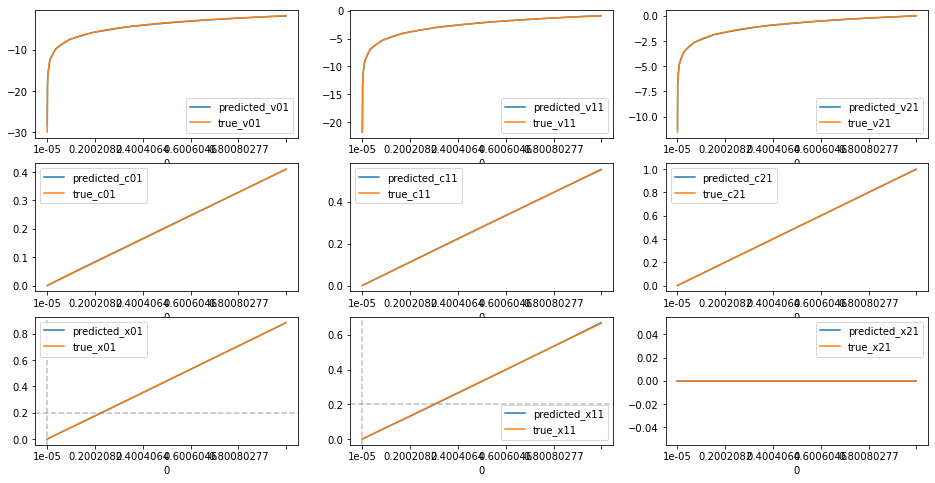

In [48]:
params = get_params(best_opt_state)
X = jnp.linspace(1e-5, 1, 1000)

init01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([1., 0., 0., 0.]), 1.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 1.)
true01 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))

init11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 1., 0., 0.]), 1.)
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 1.)
true11 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))
                                                                 
init21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 0., 1., 0.]), 1.)
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 1.)
true21 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))

                                                                 
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1),
                                   init01, pred01, init11, pred11, init21, pred21,
                                   true01, true11, true21), 
                                  axis=1)).astype(np.float32).set_index(0)
df.columns = ['initial_v01', 'initial_c01', 'initial_x01', 'initial_o11', 'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'initial_v11', 'initial_c11', 'initial_x11', 'initial_o21', 'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'initial_v21', 'initial_c21', 'initial_x21', 'initial_o31', 'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31',
              'true_v01', 'true_c01', 'true_x01', 'true_011',
              'true_v11', 'true_c11', 'true_x11', 'true_021',
              'true_v21', 'true_c21', 'true_x21', 'true_031']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])                                     
df.plot(y=['true_v01'], ax=axes.flatten()[0])
df.plot(y=['true_v11'], ax=axes.flatten()[1])
df.plot(y=['true_v21'], ax=axes.flatten()[2])
df.plot(y=['true_c01'], ax=axes.flatten()[3])
df.plot(y=['true_c11'], ax=axes.flatten()[4])
df.plot(y=['true_c21'], ax=axes.flatten()[5])
df.plot(y=['true_x01'], ax=axes.flatten()[6])
df.plot(y=['true_x11'], ax=axes.flatten()[7])
df.plot(y=['true_x21'], ax=axes.flatten()[8])
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

In [51]:
opt_state = optimizers.pack_optimizer_state(pickle.load(open('owner_only.pkl', 'rb')))
opt_init, opt_update, get_params = optimizer(step_size=1e-1)

params0 = get_params(opt_state)
OWNER_PARAMS = params0['owner']
params0 = {'owner': OWNER_PARAMS, 'renter': renter_params0}

In [55]:
@jax.jit
def neural_network(params, x, t, o):
    return jax.lax.select((o == 1.), jnp.squeeze(owner_policy(OWNER_PARAMS, x, t)), jnp.squeeze(renter_policy(params, x, t)))

In [84]:
opt_init, opt_update, get_params = optimizer(step_size=1e-3)
init_opt_state = opt_init(params0['renter'])

GRID = all_grid
W = jnp.diag(jnp.array([0., 1e-1, 1., 1.]))

if 'best_opt_state' not in globals():
    opt_state = init_opt_state
else:
    opt_state = opt_init(get_params(best_opt_state))

current_opt_state, best_opt_state = training_loop(GRID, opt_state, opt_update, get_params, W=W, max_iter=50000)

Iteration: 100	Current Loss: 893.99	Fair Loss: 181416.83	Average samples/s: 3279.30
Loss Euler: 4.15e-04	Loss Bellman: 7.73e+03	Loss FoC: 8.70e+01	Loss Envelope: 3.37e+01
Iteration: 200	Current Loss: 752.12	Fair Loss: 161569.25	Average samples/s: 3293.13
Loss Euler: 6.58e-04	Loss Bellman: 6.42e+03	Loss FoC: 7.35e+01	Loss Envelope: 3.65e+01
Iteration: 300	Current Loss: 260.37	Fair Loss: 44470.63	Average samples/s: 3301.90
Loss Euler: 6.55e-04	Loss Bellman: 1.57e+03	Loss FoC: 6.56e+01	Loss Envelope: 3.81e+01
Iteration: 400	Current Loss: 200.78	Fair Loss: 24164.49	Average samples/s: 3287.49
Loss Euler: 5.21e-04	Loss Bellman: 7.91e+02	Loss FoC: 8.35e+01	Loss Envelope: 3.82e+01
Iteration: 500	Current Loss: 205.13	Fair Loss: 23870.06	Average samples/s: 3286.79
Loss Euler: 4.73e-04	Loss Bellman: 8.71e+02	Loss FoC: 7.98e+01	Loss Envelope: 3.82e+01
Iteration: 600	Current Loss: 198.62	Fair Loss: 23862.96	Average samples/s: 3277.25
Loss Euler: 5.12e-04	Loss Bellman: 6.97e+02	Loss FoC: 8.32e+01	Lo

Iteration: 4900	Current Loss: 213.73	Fair Loss: 20290.42	Average samples/s: 3218.97
Loss Euler: 3.95e-04	Loss Bellman: 8.34e+02	Loss FoC: 9.00e+01	Loss Envelope: 4.03e+01
Iteration: 5000	Current Loss: 204.85	Fair Loss: 19986.40	Average samples/s: 3218.81
Loss Euler: 5.25e-04	Loss Bellman: 8.57e+02	Loss FoC: 7.79e+01	Loss Envelope: 4.13e+01
Iteration: 5100	Current Loss: 289.49	Fair Loss: 19794.85	Average samples/s: 3159.57
Loss Euler: 5.61e-04	Loss Bellman: 5.42e+02	Loss FoC: 7.93e+01	Loss Envelope: 1.56e+02
Iteration: 5200	Current Loss: 200.03	Fair Loss: 20236.47	Average samples/s: 3104.78
Loss Euler: 4.67e-04	Loss Bellman: 7.04e+02	Loss FoC: 8.70e+01	Loss Envelope: 4.25e+01
Iteration: 5300	Current Loss: 210.42	Fair Loss: 19474.45	Average samples/s: 3050.77
Loss Euler: 4.36e-04	Loss Bellman: 8.75e+02	Loss FoC: 8.38e+01	Loss Envelope: 3.91e+01
Iteration: 5400	Current Loss: 180.43	Fair Loss: 19395.95	Average samples/s: 3001.96
Loss Euler: 5.36e-04	Loss Bellman: 6.47e+02	Loss FoC: 7.41e+0

Iteration: 9700	Current Loss: 277.07	Fair Loss: 15320.40	Average samples/s: 2188.50
Loss Euler: 6.08e-04	Loss Bellman: 4.93e+02	Loss FoC: 8.47e+01	Loss Envelope: 1.43e+02
Iteration: 9800	Current Loss: 165.91	Fair Loss: 15365.52	Average samples/s: 2180.53
Loss Euler: 4.73e-04	Loss Bellman: 5.35e+02	Loss FoC: 7.15e+01	Loss Envelope: 4.08e+01
Iteration: 9900	Current Loss: 191.27	Fair Loss: 15449.59	Average samples/s: 2172.56
Loss Euler: 4.74e-04	Loss Bellman: 6.94e+02	Loss FoC: 7.94e+01	Loss Envelope: 4.25e+01
Iteration: 10000	Current Loss: 273.30	Fair Loss: 15671.51	Average samples/s: 2164.86
Loss Euler: 5.48e-04	Loss Bellman: 5.52e+02	Loss FoC: 6.56e+01	Loss Envelope: 1.53e+02
Iteration: 10100	Current Loss: 182.70	Fair Loss: 15378.65	Average samples/s: 2157.93
Loss Euler: 4.16e-04	Loss Bellman: 5.82e+02	Loss FoC: 7.50e+01	Loss Envelope: 4.95e+01
Iteration: 10200	Current Loss: 164.83	Fair Loss: 16575.91	Average samples/s: 2151.01
Loss Euler: 6.83e-04	Loss Bellman: 4.53e+02	Loss FoC: 7.87

Iteration: 14500	Current Loss: 139.01	Fair Loss: 14952.68	Average samples/s: 1966.11
Loss Euler: 6.35e-04	Loss Bellman: 3.63e+02	Loss FoC: 5.71e+01	Loss Envelope: 4.56e+01
Iteration: 14600	Current Loss: 148.63	Fair Loss: 12787.65	Average samples/s: 1963.05
Loss Euler: 4.65e-04	Loss Bellman: 3.60e+02	Loss FoC: 6.00e+01	Loss Envelope: 5.26e+01
Iteration: 14700	Current Loss: 252.80	Fair Loss: 13076.75	Average samples/s: 1960.70
Loss Euler: 4.33e-04	Loss Bellman: 4.63e+02	Loss FoC: 5.08e+01	Loss Envelope: 1.56e+02
Iteration: 14800	Current Loss: 166.99	Fair Loss: 12810.06	Average samples/s: 1957.71
Loss Euler: 5.14e-04	Loss Bellman: 5.44e+02	Loss FoC: 6.14e+01	Loss Envelope: 5.13e+01
Iteration: 14900	Current Loss: 243.24	Fair Loss: 12601.49	Average samples/s: 1954.96
Loss Euler: 5.99e-04	Loss Bellman: 3.51e+02	Loss FoC: 5.54e+01	Loss Envelope: 1.53e+02
Iteration: 15000	Current Loss: 153.39	Fair Loss: 12688.83	Average samples/s: 1952.08
Loss Euler: 4.84e-04	Loss Bellman: 3.51e+02	Loss FoC: 7

Iteration: 19300	Current Loss: 356.89	Fair Loss: 11577.39	Average samples/s: 1864.66
Loss Euler: 4.89e-04	Loss Bellman: 3.34e+02	Loss FoC: 5.32e+01	Loss Envelope: 2.70e+02
Iteration: 19400	Current Loss: 138.05	Fair Loss: 11346.00	Average samples/s: 1863.38
Loss Euler: 5.18e-04	Loss Bellman: 4.32e+02	Loss FoC: 4.56e+01	Loss Envelope: 4.92e+01
Iteration: 19500	Current Loss: 142.91	Fair Loss: 11782.30	Average samples/s: 1861.86
Loss Euler: 4.75e-04	Loss Bellman: 4.52e+02	Loss FoC: 4.73e+01	Loss Envelope: 5.05e+01
Iteration: 19600	Current Loss: 144.38	Fair Loss: 11795.12	Average samples/s: 1860.68
Loss Euler: 4.18e-04	Loss Bellman: 3.27e+02	Loss FoC: 5.53e+01	Loss Envelope: 5.64e+01
Iteration: 19700	Current Loss: 145.10	Fair Loss: 11473.94	Average samples/s: 1859.37
Loss Euler: 4.95e-04	Loss Bellman: 4.67e+02	Loss FoC: 4.11e+01	Loss Envelope: 5.73e+01
Iteration: 19800	Current Loss: 142.44	Fair Loss: 11915.47	Average samples/s: 1858.27
Loss Euler: 6.11e-04	Loss Bellman: 3.67e+02	Loss FoC: 5

Iteration: 24100	Current Loss: 137.39	Fair Loss: 10650.88	Average samples/s: 1808.70
Loss Euler: 4.59e-04	Loss Bellman: 3.44e+02	Loss FoC: 5.97e+01	Loss Envelope: 4.32e+01
Iteration: 24200	Current Loss: 231.96	Fair Loss: 10569.69	Average samples/s: 1807.39
Loss Euler: 4.44e-04	Loss Bellman: 3.53e+02	Loss FoC: 4.81e+01	Loss Envelope: 1.49e+02
Iteration: 24300	Current Loss: 119.84	Fair Loss: 10586.38	Average samples/s: 1806.38
Loss Euler: 4.83e-04	Loss Bellman: 2.74e+02	Loss FoC: 4.73e+01	Loss Envelope: 4.51e+01
Iteration: 24400	Current Loss: 117.37	Fair Loss: 10429.38	Average samples/s: 1805.61
Loss Euler: 5.12e-04	Loss Bellman: 3.11e+02	Loss FoC: 4.57e+01	Loss Envelope: 4.06e+01
Iteration: 24500	Current Loss: 347.70	Fair Loss: 10432.38	Average samples/s: 1804.84
Loss Euler: 5.61e-04	Loss Bellman: 3.75e+02	Loss FoC: 3.70e+01	Loss Envelope: 2.73e+02
Iteration: 24600	Current Loss: 139.78	Fair Loss: 10463.65	Average samples/s: 1804.22
Loss Euler: 5.37e-04	Loss Bellman: 3.09e+02	Loss FoC: 6

Iteration: 28900	Current Loss: 237.36	Fair Loss: 10084.81	Average samples/s: 1771.71
Loss Euler: 4.67e-04	Loss Bellman: 3.38e+02	Loss FoC: 5.35e+01	Loss Envelope: 1.50e+02
Iteration: 29000	Current Loss: 121.14	Fair Loss: 10385.21	Average samples/s: 1771.15
Loss Euler: 5.71e-04	Loss Bellman: 2.78e+02	Loss FoC: 5.09e+01	Loss Envelope: 4.24e+01
Iteration: 29100	Current Loss: 117.56	Fair Loss: 10033.30	Average samples/s: 1770.42
Loss Euler: 5.91e-04	Loss Bellman: 3.17e+02	Loss FoC: 3.92e+01	Loss Envelope: 4.67e+01
Iteration: 29200	Current Loss: 119.43	Fair Loss: 9792.88	Average samples/s: 1769.98
Loss Euler: 5.40e-04	Loss Bellman: 3.01e+02	Loss FoC: 4.68e+01	Loss Envelope: 4.25e+01
Iteration: 29300	Current Loss: 158.00	Fair Loss: 9860.01	Average samples/s: 1769.28
Loss Euler: 4.32e-04	Loss Bellman: 3.18e+02	Loss FoC: 5.86e+01	Loss Envelope: 6.76e+01
Iteration: 29400	Current Loss: 143.34	Fair Loss: 10130.12	Average samples/s: 1768.71
Loss Euler: 5.63e-04	Loss Bellman: 4.24e+02	Loss FoC: 5.1

Iteration: 33700	Current Loss: 132.27	Fair Loss: 9581.31	Average samples/s: 1745.99
Loss Euler: 5.39e-04	Loss Bellman: 3.18e+02	Loss FoC: 4.29e+01	Loss Envelope: 5.76e+01
Iteration: 33800	Current Loss: 234.97	Fair Loss: 9390.91	Average samples/s: 1745.64
Loss Euler: 5.37e-04	Loss Bellman: 3.25e+02	Loss FoC: 4.99e+01	Loss Envelope: 1.53e+02
Iteration: 33900	Current Loss: 122.25	Fair Loss: 9697.84	Average samples/s: 1745.22
Loss Euler: 5.35e-04	Loss Bellman: 2.86e+02	Loss FoC: 5.05e+01	Loss Envelope: 4.32e+01
Iteration: 34000	Current Loss: 123.96	Fair Loss: 9539.47	Average samples/s: 1745.03
Loss Euler: 4.39e-04	Loss Bellman: 2.14e+02	Loss FoC: 5.63e+01	Loss Envelope: 4.63e+01
Iteration: 34100	Current Loss: 124.25	Fair Loss: 9090.01	Average samples/s: 1744.62
Loss Euler: 5.96e-04	Loss Bellman: 4.19e+02	Loss FoC: 3.90e+01	Loss Envelope: 4.34e+01
Iteration: 34200	Current Loss: 115.89	Fair Loss: 9487.39	Average samples/s: 1744.23
Loss Euler: 5.16e-04	Loss Bellman: 2.63e+02	Loss FoC: 4.38e+0

Iteration: 38500	Current Loss: 132.73	Fair Loss: 9024.35	Average samples/s: 1727.00
Loss Euler: 5.73e-04	Loss Bellman: 3.45e+02	Loss FoC: 5.01e+01	Loss Envelope: 4.81e+01
Iteration: 38600	Current Loss: 228.29	Fair Loss: 8794.95	Average samples/s: 1726.83
Loss Euler: 5.45e-04	Loss Bellman: 2.14e+02	Loss FoC: 4.78e+01	Loss Envelope: 1.59e+02
Iteration: 38700	Current Loss: 233.92	Fair Loss: 8876.48	Average samples/s: 1726.44
Loss Euler: 4.98e-04	Loss Bellman: 3.20e+02	Loss FoC: 5.87e+01	Loss Envelope: 1.43e+02
Iteration: 38800	Current Loss: 220.92	Fair Loss: 8914.50	Average samples/s: 1726.05
Loss Euler: 5.70e-04	Loss Bellman: 2.60e+02	Loss FoC: 4.51e+01	Loss Envelope: 1.50e+02
Iteration: 38900	Current Loss: 116.85	Fair Loss: 8705.85	Average samples/s: 1725.81
Loss Euler: 3.99e-04	Loss Bellman: 2.66e+02	Loss FoC: 4.71e+01	Loss Envelope: 4.32e+01
Iteration: 39000	Current Loss: 117.13	Fair Loss: 8674.18	Average samples/s: 1725.50
Loss Euler: 5.12e-04	Loss Bellman: 2.19e+02	Loss FoC: 4.84e+0

Iteration: 43300	Current Loss: 107.10	Fair Loss: 8113.04	Average samples/s: 1712.31
Loss Euler: 4.18e-04	Loss Bellman: 2.65e+02	Loss FoC: 4.37e+01	Loss Envelope: 3.69e+01
Iteration: 43400	Current Loss: 104.06	Fair Loss: 8246.96	Average samples/s: 1712.16
Loss Euler: 4.44e-04	Loss Bellman: 1.88e+02	Loss FoC: 4.03e+01	Loss Envelope: 4.50e+01
Iteration: 43500	Current Loss: 121.41	Fair Loss: 8203.76	Average samples/s: 1711.78
Loss Euler: 3.66e-04	Loss Bellman: 3.01e+02	Loss FoC: 4.35e+01	Loss Envelope: 4.78e+01
Iteration: 43600	Current Loss: 97.76	Fair Loss: 8151.42	Average samples/s: 1711.49
Loss Euler: 5.44e-04	Loss Bellman: 2.57e+02	Loss FoC: 3.85e+01	Loss Envelope: 3.36e+01
Iteration: 43700	Current Loss: 115.06	Fair Loss: 8173.33	Average samples/s: 1711.20
Loss Euler: 5.02e-04	Loss Bellman: 3.00e+02	Loss FoC: 4.58e+01	Loss Envelope: 3.92e+01
Iteration: 43800	Current Loss: 137.57	Fair Loss: 8610.23	Average samples/s: 1711.01
Loss Euler: 5.52e-04	Loss Bellman: 1.87e+02	Loss FoC: 4.55e+01

Iteration: 48100	Current Loss: 206.25	Fair Loss: 7729.97	Average samples/s: 1703.88
Loss Euler: 4.37e-04	Loss Bellman: 2.06e+02	Loss FoC: 4.39e+01	Loss Envelope: 1.42e+02
Iteration: 48200	Current Loss: 107.02	Fair Loss: 7750.65	Average samples/s: 1703.54
Loss Euler: 5.24e-04	Loss Bellman: 1.97e+02	Loss FoC: 4.33e+01	Loss Envelope: 4.40e+01
Iteration: 48300	Current Loss: 97.24	Fair Loss: 8086.73	Average samples/s: 1703.28
Loss Euler: 4.19e-04	Loss Bellman: 2.50e+02	Loss FoC: 3.64e+01	Loss Envelope: 3.58e+01
Iteration: 48400	Current Loss: 211.76	Fair Loss: 7853.60	Average samples/s: 1703.24
Loss Euler: 4.89e-04	Loss Bellman: 2.14e+02	Loss FoC: 4.51e+01	Loss Envelope: 1.45e+02
Iteration: 48500	Current Loss: 109.05	Fair Loss: 7754.44	Average samples/s: 1703.12
Loss Euler: 3.61e-04	Loss Bellman: 2.22e+02	Loss FoC: 4.79e+01	Loss Envelope: 3.89e+01
Iteration: 48600	Current Loss: 231.83	Fair Loss: 7977.27	Average samples/s: 1702.93
Loss Euler: 4.11e-04	Loss Bellman: 2.78e+02	Loss FoC: 3.33e+01

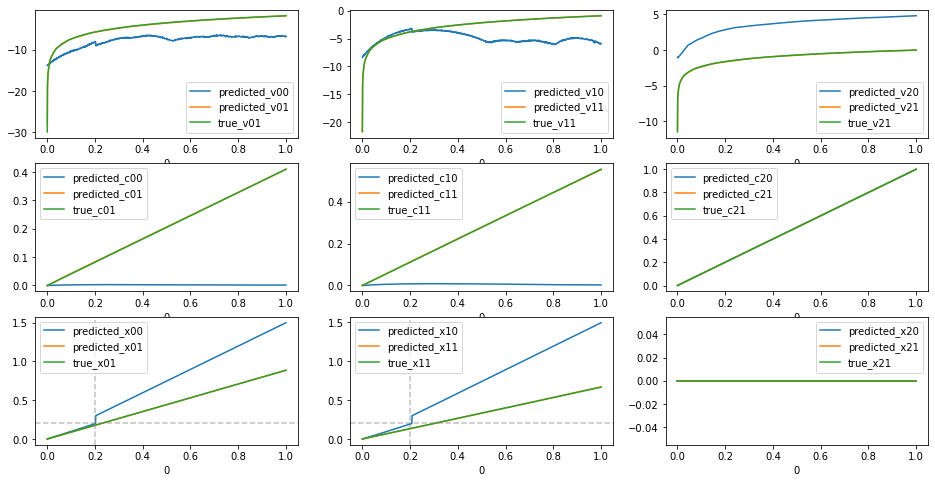

In [78]:
params = get_params(best_opt_state)

pred00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 0.)
pred10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 0.)
pred20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 0.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 1.)
true01 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 1.)
true11 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 1.)
true21 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))

                                                                 
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   pred00, pred10, pred20,
                                   pred01, pred11, pred21,
                                   true01, true11, true21), 
                                  axis=1)).astype(np.float32).set_index(0)
df.columns = ['predicted_v00', 'predicted_c00', 'predicted_x00', 'predicted_o10',
              'predicted_v10', 'predicted_c10', 'predicted_x10', 'predicted_o20', 
              'predicted_v20', 'predicted_c20', 'predicted_x20', 'predicted_o30',
              'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31',
              'true_v01', 'true_c01', 'true_x01', 'true_011',
              'true_v11', 'true_c11', 'true_x11', 'true_021',
              'true_v21', 'true_c21', 'true_x21', 'true_031']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])                                     
df.plot(y=['true_v01'], ax=axes.flatten()[0])
df.plot(y=['true_v11'], ax=axes.flatten()[1])
df.plot(y=['true_v21'], ax=axes.flatten()[2])
df.plot(y=['true_c01'], ax=axes.flatten()[3])
df.plot(y=['true_c11'], ax=axes.flatten()[4])
df.plot(y=['true_c21'], ax=axes.flatten()[5])
df.plot(y=['true_x01'], ax=axes.flatten()[6])
df.plot(y=['true_x11'], ax=axes.flatten()[7])
df.plot(y=['true_x21'], ax=axes.flatten()[8])
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

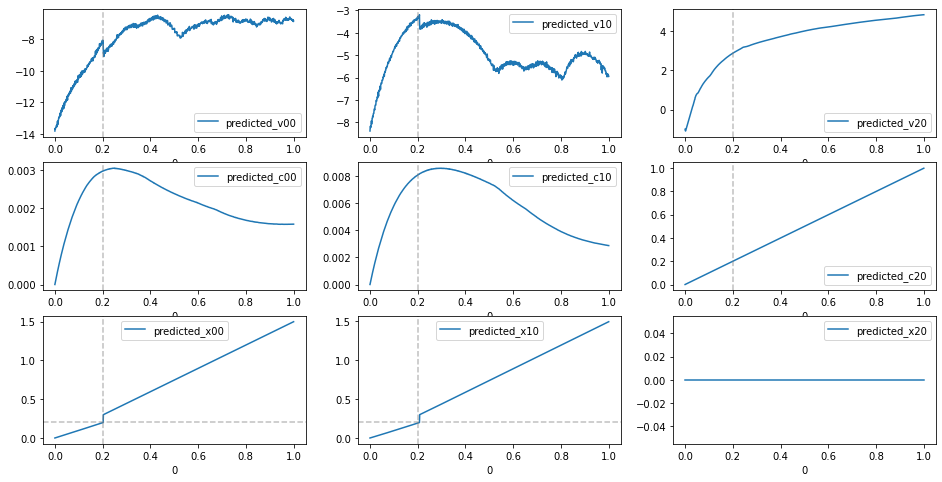

In [80]:
fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])                                   
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)
for ax in axes.flatten()[:6]:
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

In [ ]:
@jax.jit
def outputs(params, x, t, o):
    v0, c0, x1, o1 = neural_network(params, x, t, o)
    v1, c1, x2, o2 = neural_network(params, x1, increment_t(t), o1)
    
    vf = lambda params, x, t, o: neural_network(params, x, t, o)[0]
    v1r = vf(params, x1, increment_t(t), 0.)
    v1o = vf(params, x1, increment_t(t), 1.)
    v_diff = v1o - v1r
    
    c0x = jax.grad(lambda x: neural_network(params, x, t, o)[1])(x)
    v0x = jax.grad(vf, (1))(params, x, t, o)
    v1x = jax.grad(vf, (1))(params, x1, increment_t(t), o1)
    return (v0, v1, c0, v0x, v1x, c0x)

params = get_params(best_opt_state)
v0s, v1s, c0s, v0xs, v1xs, c0xs = jax.vmap(outputs, in_axes=(None, 0, 0, 0))(params, all_X, all_T, all_O)

In [ ]:
df = pd.DataFrame(jnp.concatenate((all_X.reshape(-1, 1), all_T, all_O.reshape(-1, 1), v0s.reshape(-1, 1), v1s.reshape(-1, 1), c0s.reshape(-1, 1), v0xs.reshape(-1, 1), v1xs.reshape(-1, 1), c0xs.reshape(-1, 1)), axis=1), columns=['X', 't0', 't1', 't2', 't3', 'O', 'v0', 'v1', 'c0', 'v0x', 'v1x', 'c0x'])

In [ ]:
df['lhs'] = df['c0x']
df['rhs'] = df['c0'] * df['v0x']
df[(df['O'] == 0.) & (df['t0'] == 1.)].plot(x='X', y=['lhs', 'rhs'])

In [ ]:
df[(df['O'] == 0.) & (df['t0'] == 1.) & (df['X'] > 0.1)].plot(x='X', y=['v0x'])

In [ ]:
df[(df['O'] == 0.) & (df['t0'] == 1.)].plot(x='X', y=['v0', 'v1'])

In [ ]:
df[(df['O'] == 0.) & (df['t0'] == 1.)].plot(x='X', y='c0x')

In [ ]:
trained_params = optimizers.unpack_optimizer_state(opt_init({'owner': OWNER_PARAMS, 'renter': get_params(best_opt_state)}))
pickle.dump(trained_params, open('owner_only.pkl', 'wb'))